In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

import pickle

%load_ext autoreload
%autoreload 3

### Load data, reload (individual) trained model, and make predictions 

In [2]:
psd = xr.load_dataset('../../data/Processed/psd_wave.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

In [6]:
psd

<xarray.Dataset>
Dimensions:  (time: 10073)
Coordinates:
  * time     (time) datetime64[ns] 1996-12-22T19:00:00.288000 ... 2016-04-13T...
Data variables: (12/26)
    taucx    (time) float64 0.1895 0.6395 0.3934 ... 0.07723 0.07373 0.08168
    taucy    (time) float64 0.0333 0.1182 -0.023 ... -0.06492 -0.02255 -0.0589
    hsc      (time) float64 -29.54 -100.4 -60.81 -142.7 ... -5.808 1.075 -13.14
    hlc      (time) float64 -99.11 -180.2 -153.9 -218.3 ... -39.32 -43.95 -109.2
    U        (time) float64 12.14 16.7 16.75 17.0 ... 9.779 8.903 8.239 8.543
    tsea     (time) float64 7.569 11.82 11.86 11.91 ... 11.43 10.9 11.38 12.66
    ...       ...
    plp0     (time) float64 35.55 111.3 111.7 112.0 112.3 ... 0.0 0.0 0.0 0.0
    pdir0    (time) float64 39.06 72.15 72.69 73.58 74.38 ... 0.0 0.0 0.0 0.0
    phs1     (time) float64 0.121 0.6146 0.5992 0.5875 ... 3.759 3.677 3.366
    plp1     (time) float64 90.67 162.9 162.3 161.2 ... 378.4 363.1 356.7 343.2
    pdir1    (time) float64 114.4 220.1 219.3 219.0 ... 238.7 236.6 236.1 235.3
    wdir     (time) float64 75.04 68.66 65.81 66.5 ... 284.7 282.9 270.4 283.4

In [3]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

def plot_feature(ax, X, Y_truth, Y_pred, LEGEND=True):
    mse = torch.mean((Y_truth-Y_pred)**2)
    r2 = 1 - mse/torch.var(Y_truth)
    ax.plot(X,Y_truth, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Measurements')
    ax.plot(X,Y_pred, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='ANN Prediction (mean)')
    if LEGEND:
        ax.legend(fancybox=False)

#### Momentum flux

In [4]:
i = 5
filename = "../../saved_model/full_anns_diff_momentum_3layers_split%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)

Text(0, 0.5, 'Momentum flux $\\tau_x \\; [N/m^2]$')

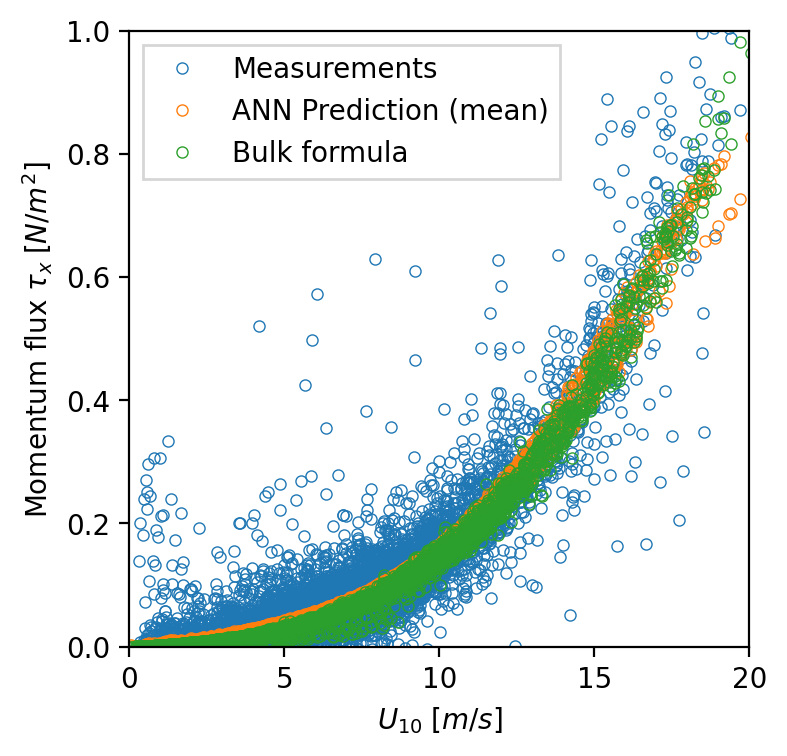

In [8]:
# no weights
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,0], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,0], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')

ax.legend(fancybox=False)
ax.set_ylim([0,1]); ax.set_xlim([0,20])
ax.set_xlabel('$U_{10} \; [m/s]$'); ax.set_ylabel(r'Momentum flux $\tau_x \; [N/m^2]$')

#### Heat Flux

In [30]:
i = 0
filename = "../../saved_model/full_anns_diff_sensible_3layers_split%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)

Text(0, 0.5, 'Sensible heat flux $Q_s \\; [W/m^2]$')

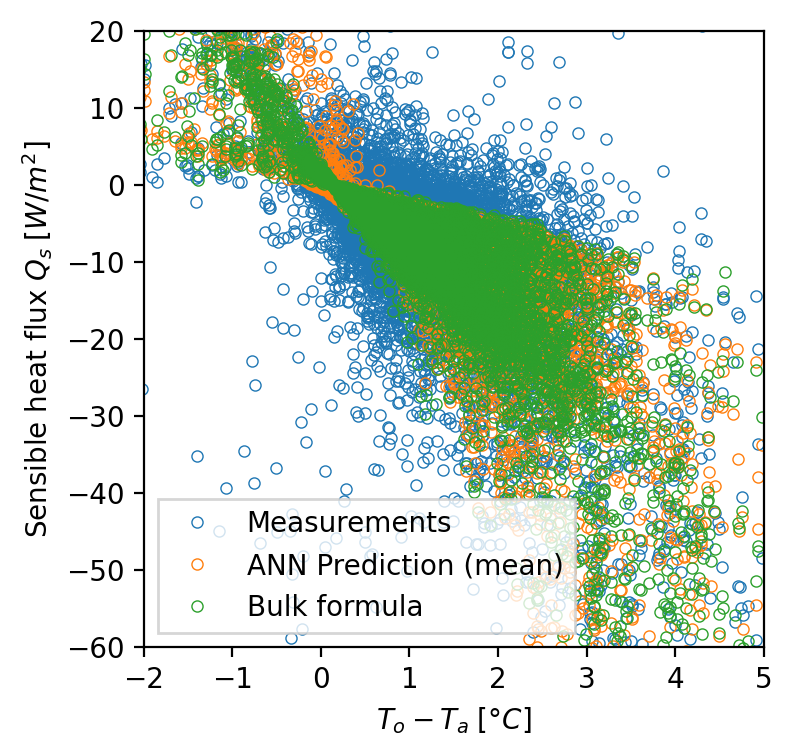

In [31]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,1]-vd.X[:,2], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,1]-vd.X[:,2], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([-60,20]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_o-T_a \; [\degree C]$'); ax.set_ylabel('Sensible heat flux $Q_s \; [W/m^2]$')